In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit
from qiskit.result import ProbDistribution
from qiskit.visualization import plot_distribution
from circuit_knitting.cutting.cutqc import reconstruct_full_distribution, cut_circuit_wires, evaluate_subcircuits
from backend import fake_backend, transpiler_fake_backend, sampler_fake_backend
from utils import save_cuts, save_probs, save_reconstructed_probs

In [16]:
FILE_PREFIX = "28-qubits-GHZ"

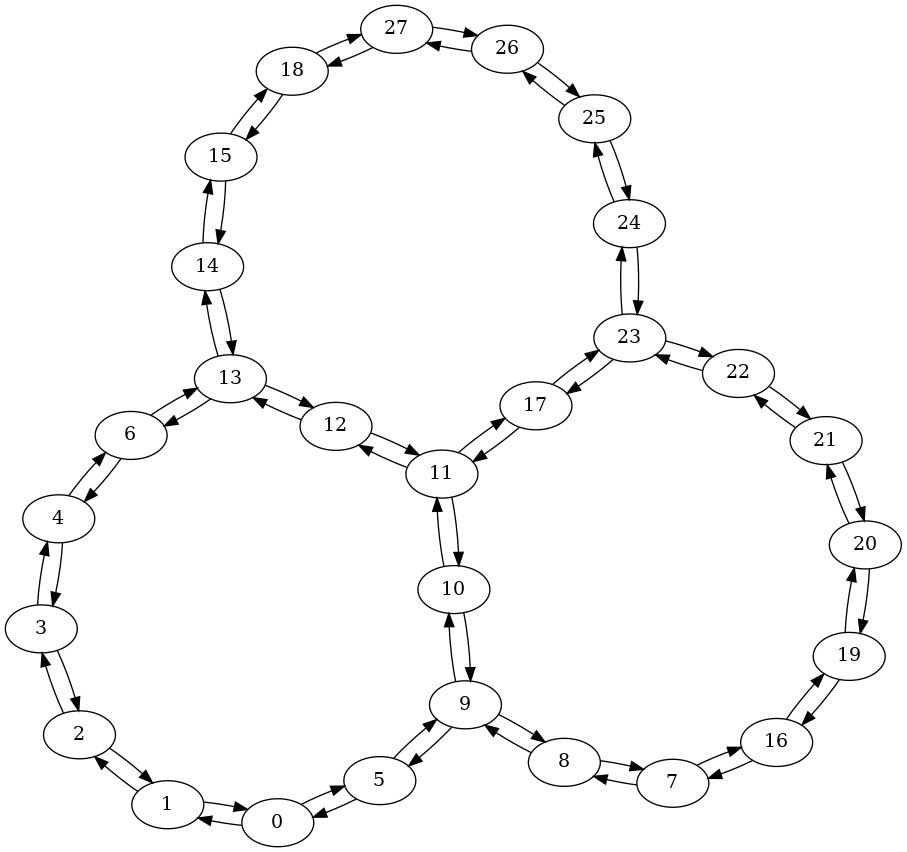

In [2]:
fake_backend.coupling_map.draw()

In [3]:
starting_node = 10
couplings = [
    (10, 9),
    (10, 11),
    (9, 8),
    (9, 5),
    (5, 0),
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (4, 6),
    (6, 13),
    (8, 7),
    (7, 16),
    (16, 19),
    (19, 20),
    (20, 21),
    (21, 22),
    (22, 23),
    (11, 12),
    (11, 17),
    (13, 12),
    (13, 14),
    (14, 15),
    (15, 18),
    (18, 27),
    (27, 26),
    (26, 25),
    (25, 24)
]

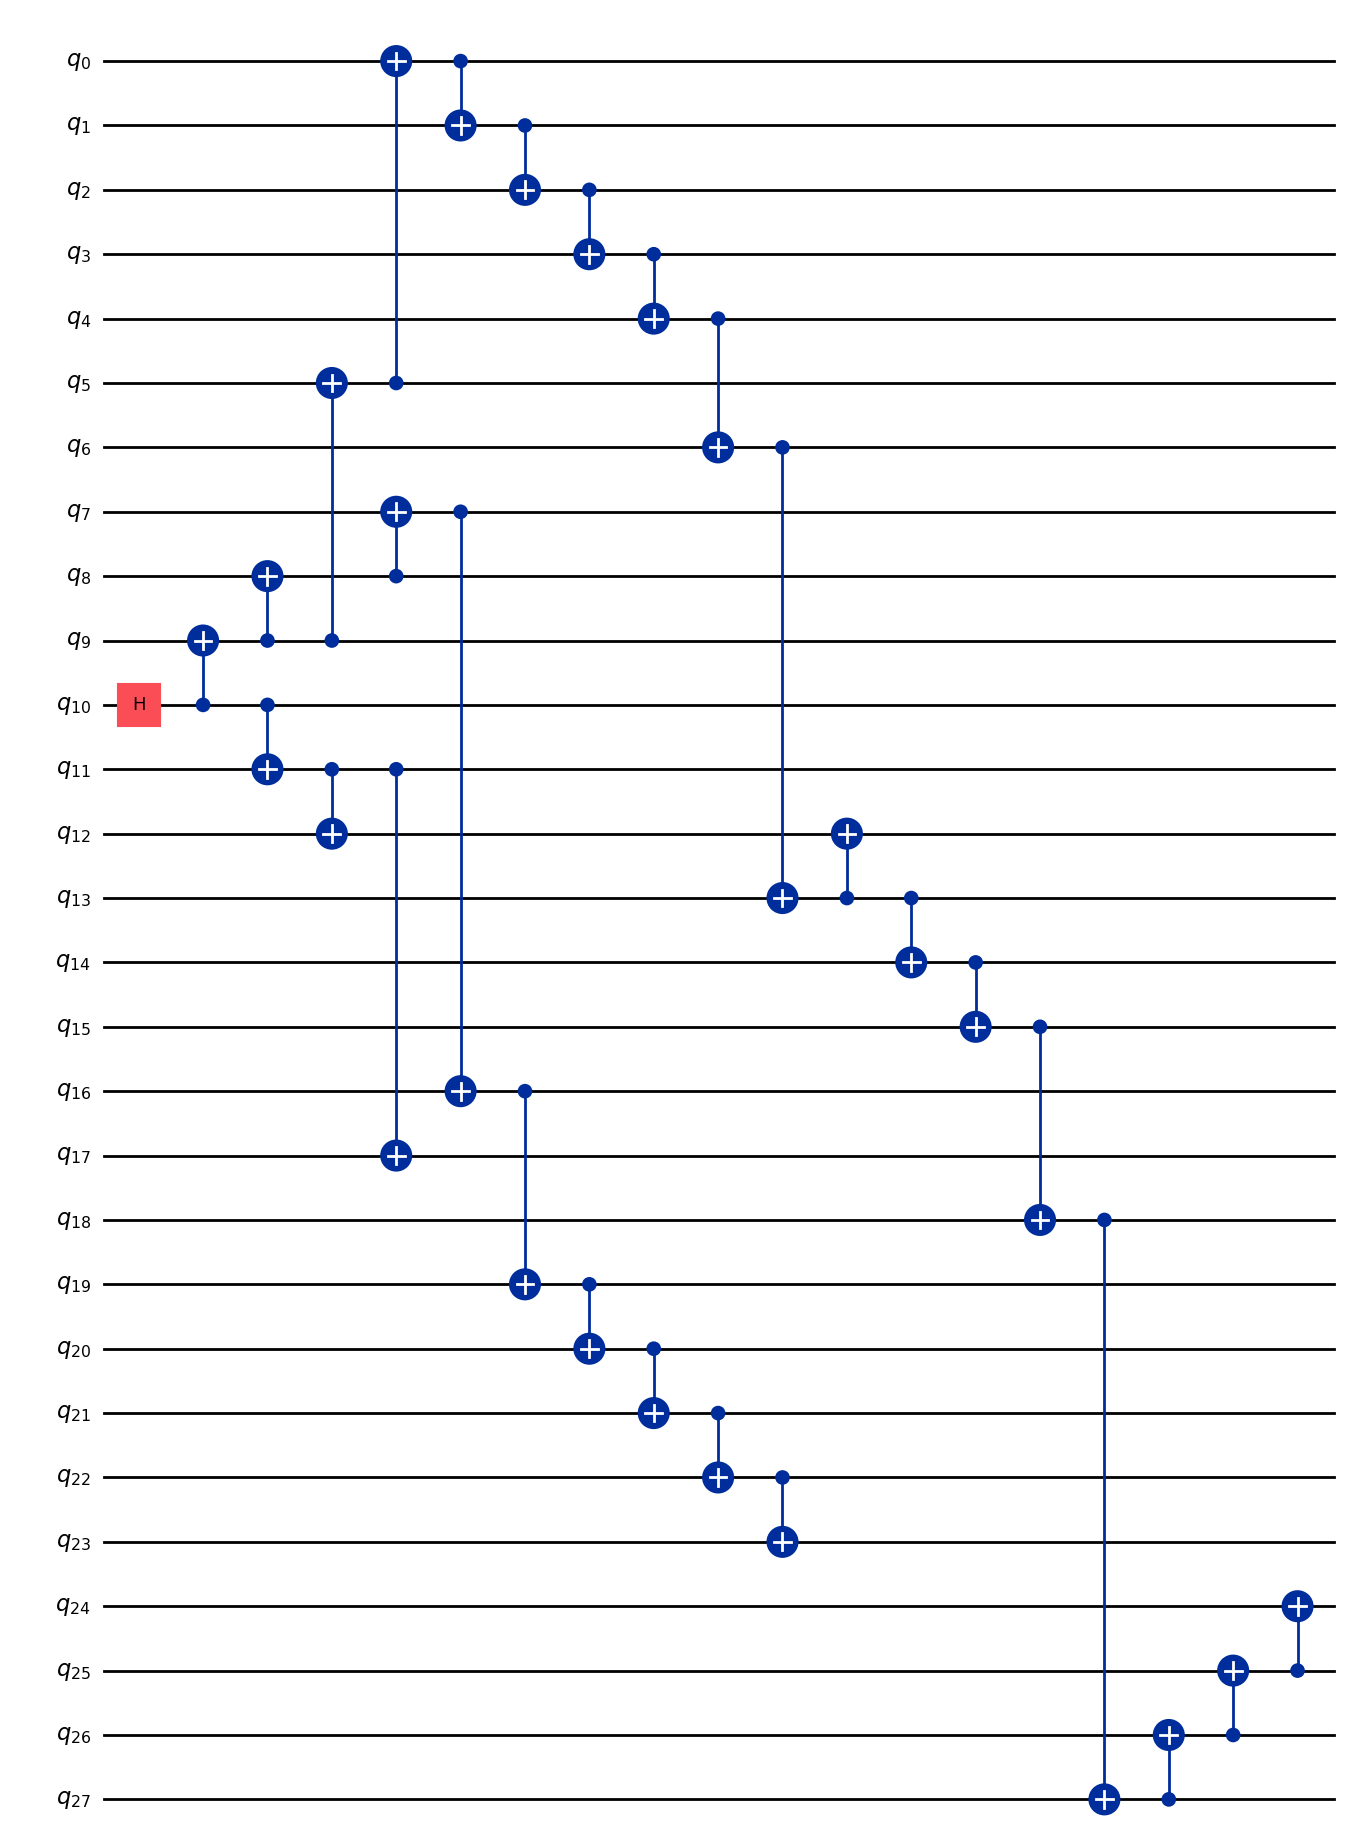

In [ ]:
n_qubits = fake_backend.num_qubits
qc = QuantumCircuit(n_qubits)
qc.h(starting_node)
for i,j in couplings:
    qc.cx(i,j)
qc.draw('mpl', filename="28-qubits-GHZ-circuit.png")

In [14]:
qc_c = qc.copy()
qc_c.measure_all()
transpiled_qc = transpiler_fake_backend.run(qc_c)
print(f'qc depth: {qc_c.depth()}')
print(f'transpiled qc depth: {transpiled_qc.depth()}')

qc depth: 20
transpiled qc depth: 20


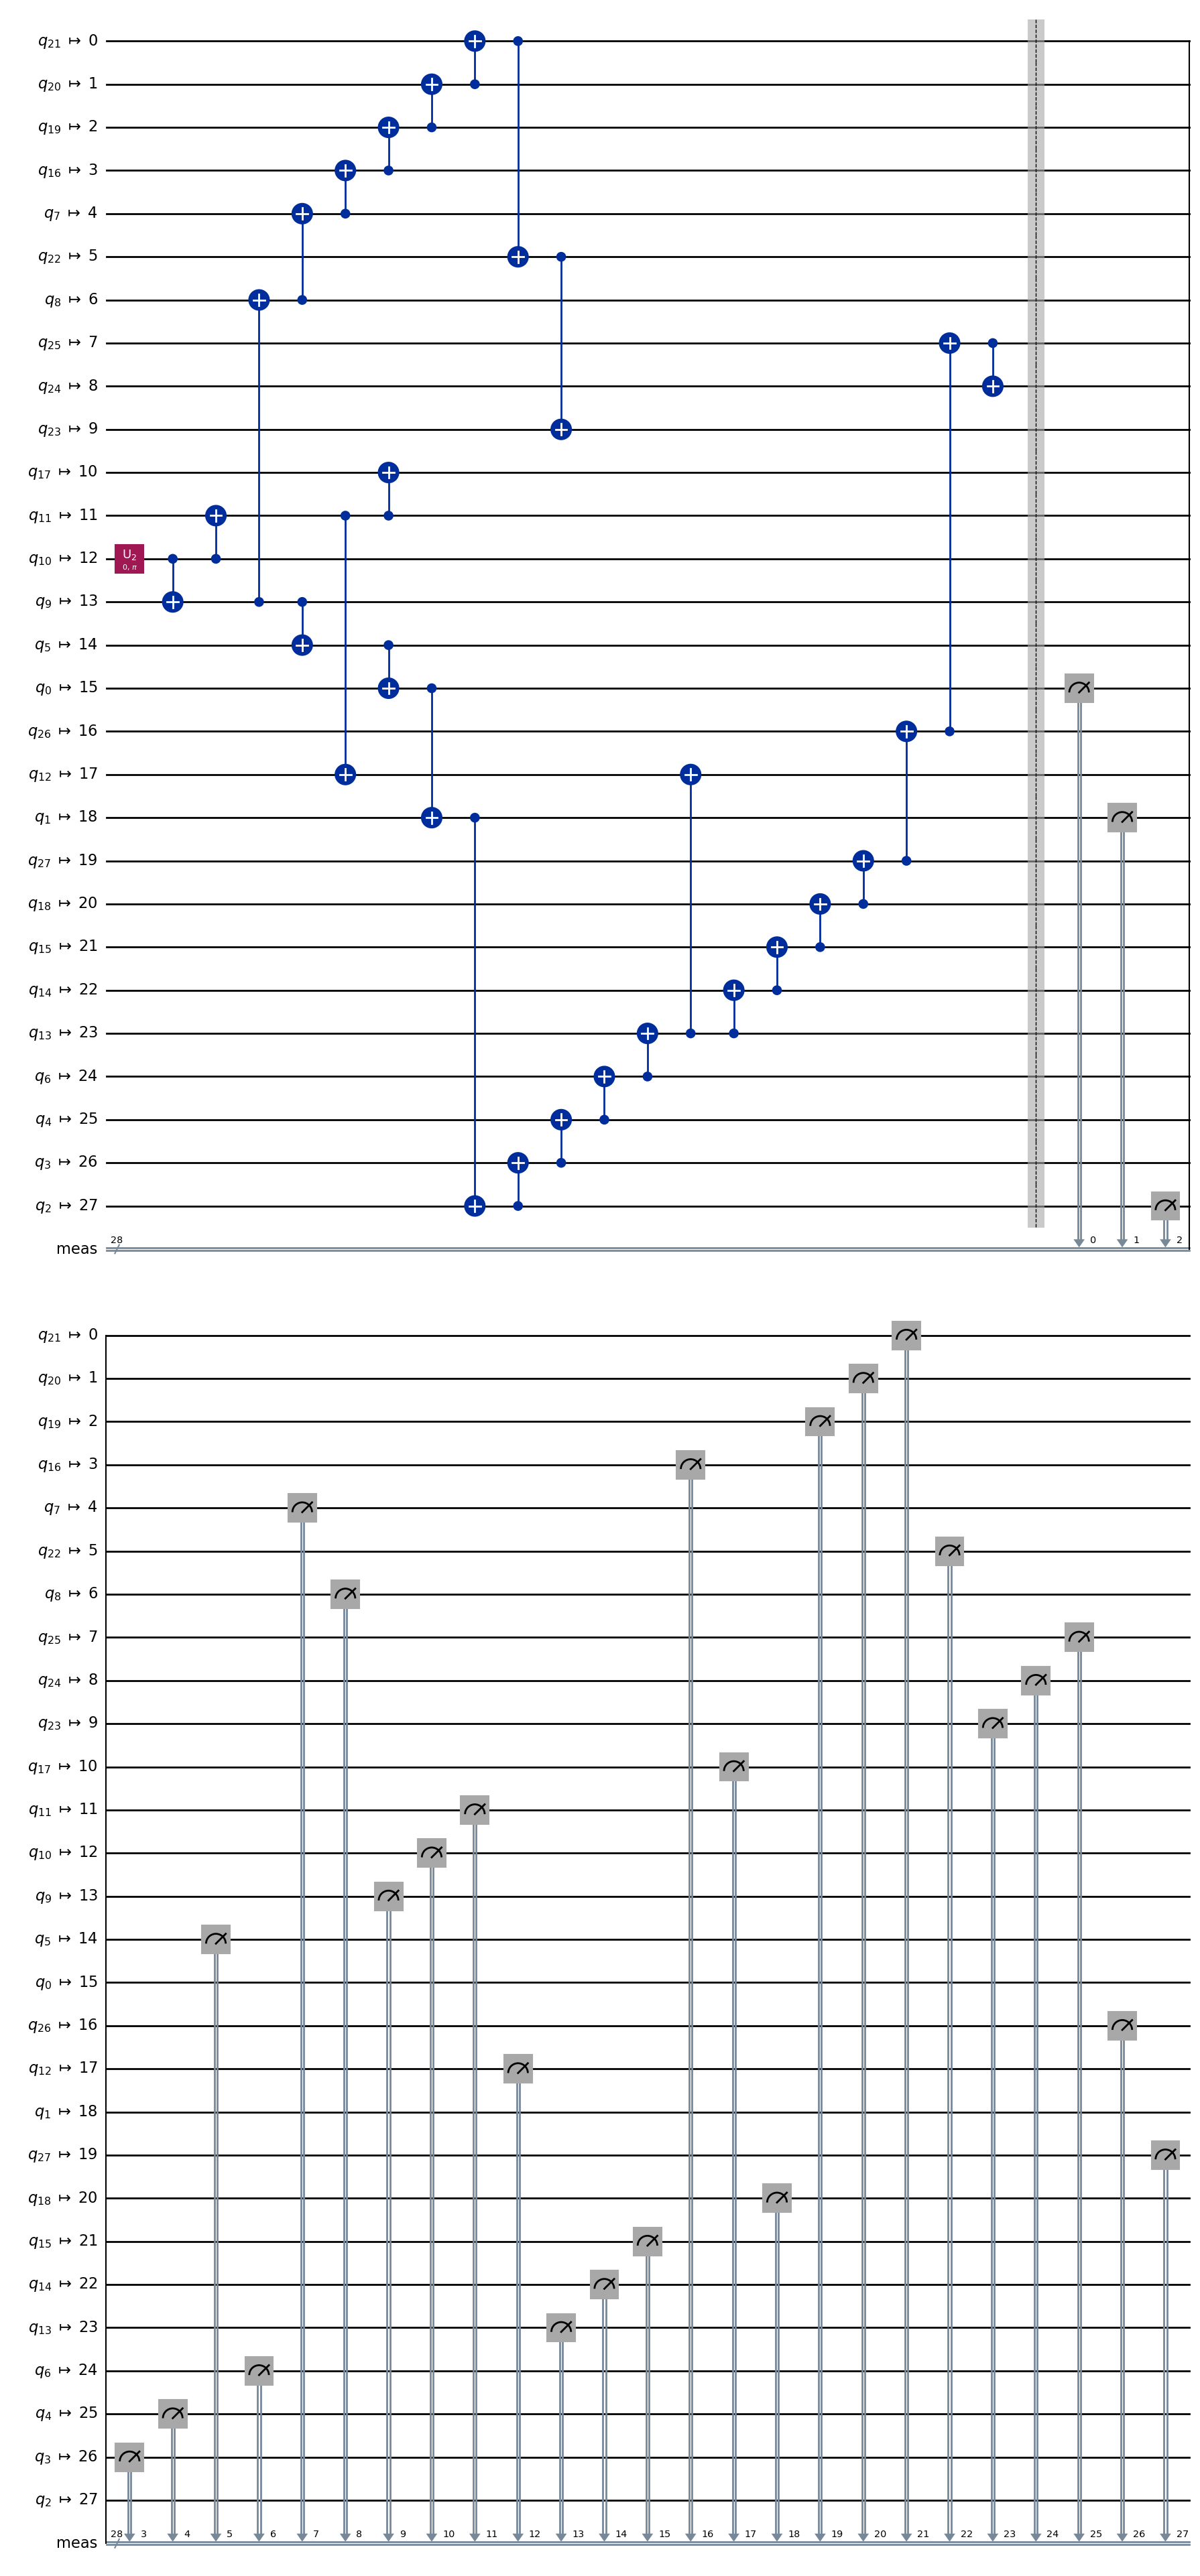

In [6]:
transpiled_qc.draw('mpl')

In [40]:
dist = sampler_fake_backend.run([transpiled_qc]).result().quasi_dists
fig = plot_distribution(dist)
fig.savefig("28-qubits-GHZ-dist.png")
display(fig)

In [24]:
cuts = cut_circuit_wires(
    circuit=qc,
    method="manual",
    subcircuit_vertices=[list(range(7)), list(range(7,15)), list(range(15,22)), list(range(22,28))]
)
save_cuts(cuts, FILE_PREFIX)


--------------------
num_cuts = 7
subcircuit 0
ρ qubits = 0, O qubits = 3, width = 8, effective = 5, depth = 7, size = 8
                              ┌───┐          
q_0: ─────────────────────────┤ X ├──■───────
                              └─┬─┘┌─┴─┐     
q_1: ───────────────────────────┼──┤ X ├──■──
                                │  └───┘┌─┴─┐
q_2: ───────────────────────────┼───────┤ X ├
                         ┌───┐  │       └───┘
q_3: ────────────────────┤ X ├──■────────────
                    ┌───┐└─┬─┘               
q_4: ───────────────┤ X ├──┼─────────────────
               ┌───┐└─┬─┘  │                 
q_5: ──────────┤ X ├──■────┼─────────────────
          ┌───┐└─┬─┘       │                 
q_6: ─────┤ X ├──■─────────■─────────────────
     ┌───┐└─┬─┘                              
q_7: ┤ H ├──■────────────────────────────────
     └───┘                                   
subcircuit 1
ρ qubits = 2, O qubits = 2, width = 9, effective = 7, depth = 6, size = 8
          

In [25]:
subcircuit_instance_probabilities = evaluate_subcircuits(cuts)
save_probs(subcircuit_instance_probabilities,FILE_PREFIX)

Saving probabilities as JSON...


In [ ]:
reconstructed_probabilities = reconstruct_full_distribution(
    qc, subcircuit_instance_probabilities, cuts
)
save_reconstructed_probs(reconstructed_probabilities, FILE_PREFIX)

In [ ]:
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=n_qubits)

In [ ]:
fig = plot_distribution(reconstructed_dict_bitstring)
fig.savefig(f"{FILE_PREFIX}-circuit-cutting-dist.png")
display(fig)